# Idea
Where we describe how we'll do recommendations. We assume we have scrapped a good portion of past events, clustered them and have saved the centroids. We also assume we have this week's events embeddings.

This is also meant to be a playground to try out new ideas so it might be a little messy.

In [9]:
import requests, json, pickle, urllib, time, random, os
from bs4 import BeautifulSoup
import numpy as np
# import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

In [10]:
# First load everything
centroids = np.load('../data/centroids.npy')
current_embs = np.load('../data/current_embs.npy')
# with open('../data/cluster_data/kmeans_model.pkl', 'rb') as f: m = pickle.load(f)
centroids.shape, current_embs.shape

((1000, 1536), (641, 1536))

In [11]:
# Then compute the euclidian distances of new embeddings to the centroids
# Could do it manually but can use sklearn's optimized function
# Note: could also use m.transform(current_embs) but we could avoid loading the model this way
dists_to_centroids = euclidean_distances(current_embs, centroids)
dists_to_centroids.shape

(641, 1000)

In [13]:
# We'll imagine that users "rate clusters". I.e. we'll maintain a (n_clusters,) vector "rating" each of the clusters
# TODO: determine how to initialize
sd = 0.001
user_ratings = np.random.randn(len(centroids)) * sd
user_ratings[0] = 2
user_ratings.shape, user_ratings.mean(), user_ratings.std()

((1000,), np.float64(0.0020037413034603917), np.float64(0.06322157872878849))

In [14]:
# We'll weight how much each cluster can say about each event by how far away they are
eps = 1e-5
weights = (1 / (dists_to_centroids + eps))
weights /= weights.sum(axis=1)[:, np.newaxis]
weights.shape

(641, 1000)

(array([169., 649., 102.,  25.,  16.,  14.,  17.,   5.,   1.,   2.]),
 array([0.00080249, 0.00091715, 0.0010318 , 0.00114645, 0.0012611 ,
        0.00137575, 0.0014904 , 0.00160505, 0.00171971, 0.00183436,
        0.00194901]),
 <BarContainer object of 10 artists>)

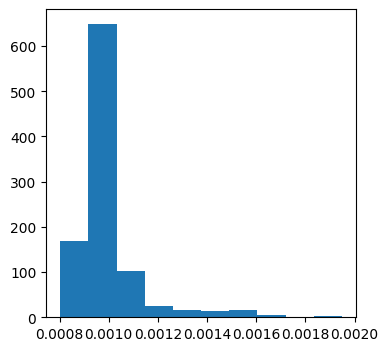

In [112]:
plt.figure(figsize=(4,4)); plt.hist(weights[-2])

In [15]:
preds = (weights @ user_ratings)
preds.shape

(641,)

(array([121., 250., 145., 103.,  11.,   2.,   2.,   1.,   0.,   9.]),
 array([0.0017311 , 0.00183293, 0.00193475, 0.00203658, 0.00213841,
        0.00224023, 0.00234206, 0.00244388, 0.00254571, 0.00264753,
        0.00274936]),
 <BarContainer object of 10 artists>)

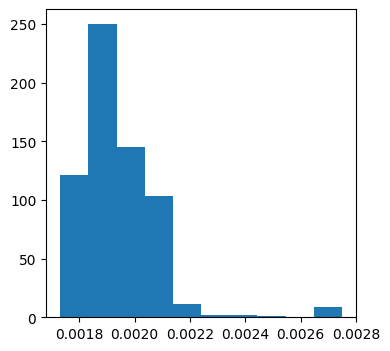

In [99]:
plt.figure(figsize=(4,4)); plt.hist(preds)

In [16]:
(-preds).argsort()

array([357, 277, 620, 516, 356, 134, 228,  68,  30, 402, 257, 410, 401,
       540, 534, 437, 298,  94, 166,   7, 577,  45, 256, 547, 529, 152,
       559, 636, 417, 502,  27, 618,  14, 314,   8, 617, 438, 299, 579,
       612, 584, 601, 594,  96, 168, 458, 598,  46, 114, 188, 525, 291,
       315, 189, 599, 115, 459,  15, 307, 446,  28, 176, 102,   9,  52,
       442, 303, 581, 172,  99,  49, 629, 382, 443, 583, 483,  19, 605,
       420, 414, 194, 469,  10, 322, 600, 466, 190, 509, 626, 478, 422,
       365, 493, 462, 546, 520,  23, 441, 302,  31, 610, 170, 318, 426,
        98,  48, 623, 187, 597, 457, 192, 435, 294,  20, 295, 161, 434,
        91,  92,  43, 162,  44, 465, 558, 270, 407, 486, 535,  11, 596,
       309, 452, 627,  24, 632, 611, 111,  29, 184, 619,  17, 602, 537,
       313, 513, 411, 562, 268,  21, 311, 634, 159, 550, 207, 621,  83,
       164, 283, 387, 416, 484, 202, 132,  25, 306, 423, 175, 445, 639,
       101,  51, 633, 613, 421, 557,   2, 135, 282,  85,  37, 44

In [21]:
weights[0].argmax()

np.int64(444)

In [23]:
(weights[0] * 2).sum()

np.float64(2.0)

In [31]:
# user rated the event 0 as 2:
user_ratings += 2 * weights[0]